In [ ]:
pip uninstall numpy matplotlib


In [2]:
pip install numpy


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip uninstall numpy matplotlib


^C
Note: you may need to restart the kernel to use updated packages.


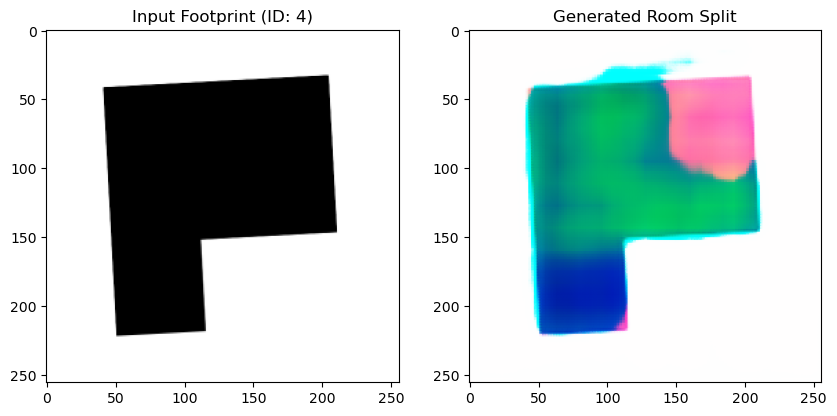

Generated image for ID 4 saved to database with email: default123@example.com


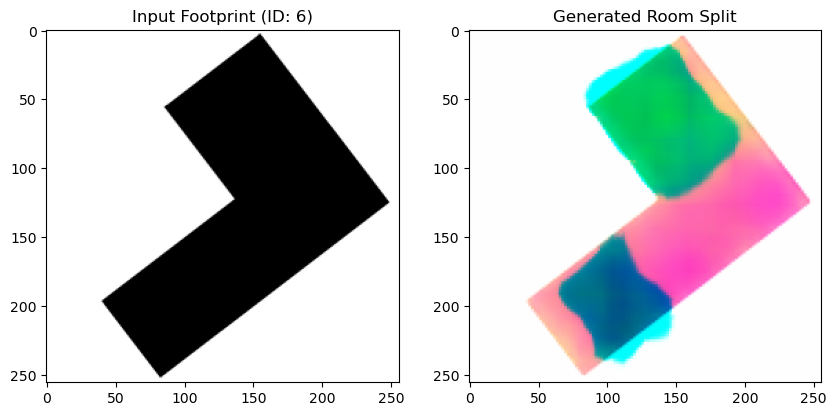

Generated image for ID 6 saved to database with email: default123@example.com


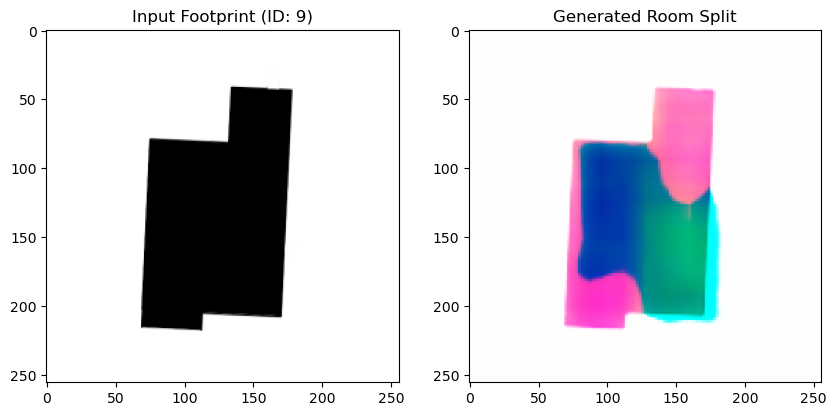

Generated image for ID 9 saved to database with email: default123@example.com


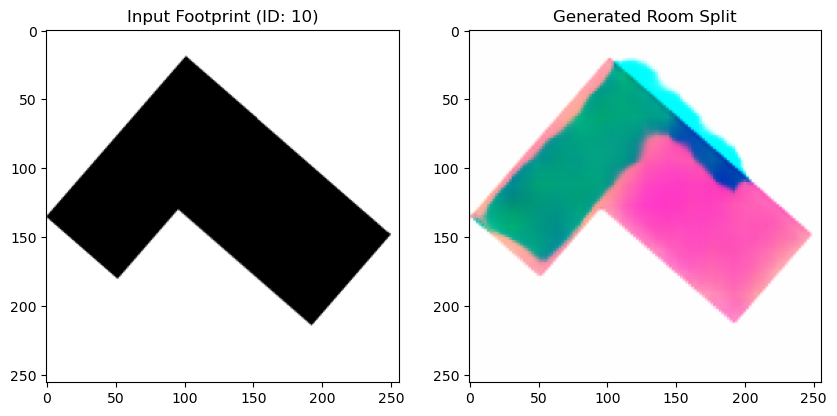

Generated image for ID 10 saved to database with email: default123@example.com


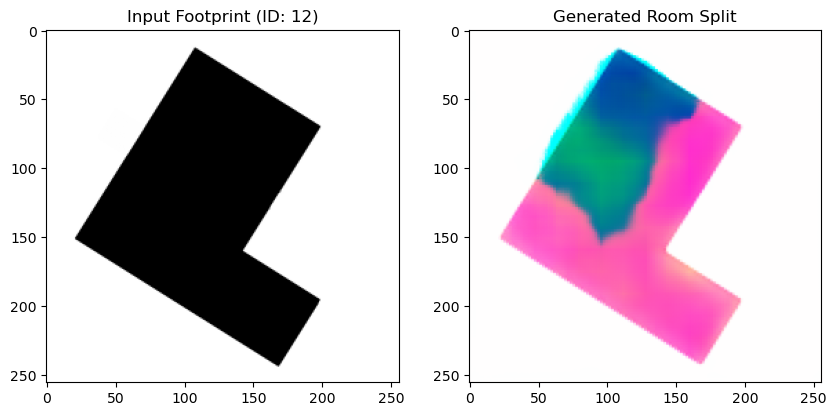

Generated image for ID 12 saved to database with email: default123@example.com


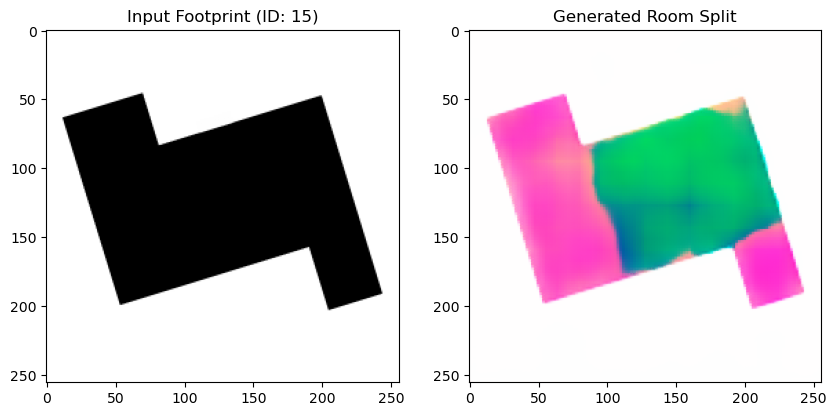

Generated image for ID 15 saved to database with email: default123@example.com


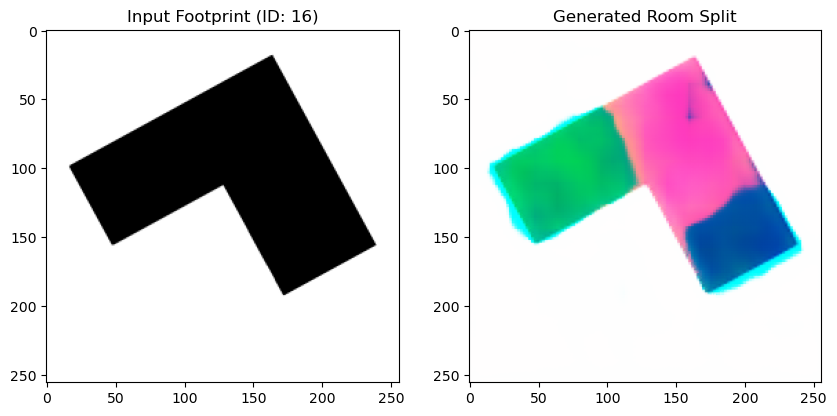

Generated image for ID 16 saved to database with email: default123@example.com


In [29]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import mysql.connector
from tensorflow.keras.models import load_model

# Database connection setup
conn = mysql.connector.connect(
    host="localhost",
    user="root",  # Replace with your MySQL username
    password="1111",  # Replace with your MySQL password
    database="apexadb"
)
cursor = conn.cursor()

# Paths to the generator model
generator_path = r'2dModelTest_h5/generator_epoch_50.h5'  # Update path as needed

# Load the pre-trained generator
generator = load_model(generator_path, compile=False)

# Function to preprocess an image for the generator
def preprocess_image(image_blob):
    """
    Preprocess image data from the database for the generator.
    """
    img = tf.image.decode_image(image_blob, channels=3)  # Decode image from binary
    img = tf.image.resize(img, [256, 256])  # Resize to match the model's input size
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return img

# Retrieve all input images from the database
cursor.execute("SELECT id, image_data, email FROM user_input_image  ORDER BY id")
image_rows = cursor.fetchall()

if image_rows:
    for image_row in image_rows:
        input_image_id, input_image_blob, user_email  = image_row

        # Preprocess the retrieved image
        input_image = preprocess_image(input_image_blob)

        # Add a batch dimension for the generator
        input_image = tf.expand_dims(input_image, axis=0)

        # Generate the room split using the pre-trained model
        predicted_split = generator(input_image, training=False)

        # Display the input and output images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f"Input Footprint (ID: {input_image_id})")
        plt.imshow((input_image[0] + 1) / 2)  # De-normalize to [0, 1] range

        plt.subplot(1, 2, 2)
        plt.title("Generated Room Split")
        plt.imshow((predicted_split[0] + 1) / 2)  # De-normalize to [0, 1] range

        plt.show()

        # Convert the generated output back to binary for database insertion
        output_image_array = tf.keras.preprocessing.image.img_to_array(
            (predicted_split[0] + 1) * 127.5
        ).astype(np.uint8)

        # Encode the image to PNG format
        _, encoded_output = cv2.imencode('.png', output_image_array)

        # Insert the output image into the 3dmodelinput table
        insert_query = """
        INSERT INTO 3dmodelinput (image_data, email) VALUES (%s, %s)
        """
        # Use a placeholder or default email if no email is associated
        email_to_insert = "default123@example.com"
        cursor.execute(insert_query, (encoded_output.tobytes(), email_to_insert))
        conn.commit()

        print(f"Generated image for ID {input_image_id} saved to database with email: {email_to_insert}")
else:
    print("No input images found in the database!")

# Close the database connection
conn.close()


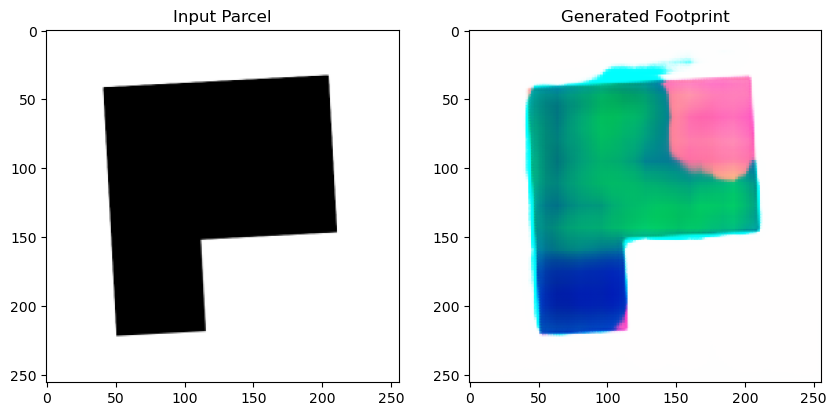

In [37]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import mysql.connector

# Paths to the generator model and test image
generator_path = r'2dModelTest_h5/generator_epoch_50.h5'  # Update path as needed
test_image_path = r'D:/Final_Project/2nd/testingModel/2dModel/testFootPrint/footprint_16.png'  # Update path as needed

# Paths to save the intermediate images
input_save_path = r'input_image.png'
output_save_path = r'generated_image.png'

# Database connection setup
conn = mysql.connector.connect(
    host="localhost",
    user="root",  # Replace with your MySQL username
    password="1111",  # Replace with your MySQL password
    database="apexa_db"
)
cursor = conn.cursor()

# Load the pre-trained generator
generator = load_model(generator_path, compile=False)

# Function to preprocess the test image
def preprocess_image(image_path):
    """
    Load and preprocess a test image for the generator.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)  # Adjust channels as needed
    img = tf.image.resize(img, [256, 256])  # Resize to match the model's input size
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return img

# Preprocess the test image
input_image = preprocess_image(test_image_path)

# Add a batch dimension for the generator
input_image = tf.expand_dims(input_image, axis=0)

# Generate room split using the pre-trained model
predicted_split = generator(input_image, training=False)

# Save the input and output images locally
tf.keras.preprocessing.image.save_img(
    input_save_path, (input_image[0] + 1) * 127.5  # Convert back to [0, 255] range
)
tf.keras.preprocessing.image.save_img(
    output_save_path, (predicted_split[0] + 1) * 127.5  # Convert back to [0, 255] range
)

# Display the input and output images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Parcel")
plt.imshow((input_image[0] + 1) / 2)  # De-normalize to [0, 1] range

plt.subplot(1, 2, 2)
plt.title("Generated Footprint")
plt.imshow((predicted_split[0] + 1) / 2)  # De-normalize to [0, 1] range
plt.show()


import mysql.connector

def insert_processed_image_to_database(final_image, email):
    """
    Insert the processed image (as binary data) into the '3dmodelinput' table in the database.
    """
    try:
        if final_image is None:
            print("Error: The processed image is None.")
            return
        
        # Encode the final image to PNG format
        _, encoded_image = cv2.imencode('.png', final_image)
        if encoded_image is None:
            print("Error: Failed to encode the image.")
            return
        
        binary_data = encoded_image.tobytes()
        print(f"Binary data size: {len(binary_data)} bytes")
        
        insert_query = """
        INSERT INTO 3dmodelinput (image_data, email) VALUES (%s, %s)
        """
        email_to_insert = "default1234@example.com"
        print("Executing query...")
        cursor.execute(insert_query, (binary_data, email_to_insert))
        conn.commit()
        print("Image saved successfully.")
    
    except mysql.connector.Error as err:
        print(f"MySQL Error: {err}")
        print(f"Error Code: {err.errno}, SQL State: {err.sqlstate}")
    
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()
            print("Database connection closed.")

